# Model Preprocessing (XGBoost)
## EV Survey 

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import numpy as np
#------------------------
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
#-------------------------
from os import listdir
from os.path import isfile, join
import pprint
import os 
from pathlib import Path

Objective
* Evaluate feature relationships
* Evaluate statistical relationship strengths using Pearson or other method

In [20]:
def seabornhist(size=(10,10), data=None, hue_c=None, x=None):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.histplot(x=x, data= data, hue = hue_c, ax=ax)
    plt.show()
    return

def seaborncount(size=(10,10), data=None, hue_c=None, x=None):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.countplot(x=x, data= data, hue = hue_c, ax=ax)
    plt.show()
    return

In [21]:
#collect info about current working directory and the location of the raw data pickle files

wd = Path(os.getcwd())
parent_dir = wd.parent.absolute()

In [22]:
#Data for the EV survey
filename = "processed_data.pkl"
filepath = f"{wd}\\{filename}"
df = pd.read_pickle(filepath)

In [23]:

df.drop(columns=['response_id'] , inplace=True)
df.head()

,months_owned,electric_range,discontinuance,surveyed_age,dist_1,trips_greater_200,safety_satisfaction,comfort_satisfaction,refuel_recharge_satisfaction,performance_satisfaction,...,highest_charge_used_level 1 & level 2,"highest_charge_used_level 1, level 2 & dc fast",highest_charge_used_level 2,highest_charge_used_level 2 & dc fast,highest_charge_used_no charging,surveyed_gender_decline to state,surveyed_gender_female,surveyed_gender_genderqueer/non-binary,surveyed_gender_male,surveyed_gender_transfemale/transwoman
0,24.0,81.0,continued,25.0,13.92,0.0,5.0,5.0,5.0,5.0,...,0,0,1,0,0,0,0,0,1,0
6,14.0,87.0,continued,35.0,8.54,0.0,2.0,2.0,3.0,2.0,...,0,0,1,0,0,0,0,0,1,0
9,48.0,84.0,discontinued,55.0,12.91,0.0,3.0,2.0,3.0,2.0,...,0,0,0,0,1,0,0,0,1,0
10,30.0,81.0,continued,55.0,9.43,0.0,4.0,4.0,5.0,4.0,...,0,0,0,0,1,0,0,0,1,0
11,31.0,84.0,continued,35.0,16.32,0.0,5.0,5.0,5.0,4.0,...,1,0,0,0,0,0,0,0,1,0


In [24]:
df_preprocessed = df

In [25]:
df_preprocessed.discontinuance
y = df_preprocessed.discontinuance
y.head()
df_preprocessed.drop(columns = 'discontinuance', inplace=True)
X = df_preprocessed

In [26]:
# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [27]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [28]:
clf = RandomForestClassifier(n_estimators=500, criterion='gini',  random_state = 1,n_jobs=-1, max_features = 'auto', class_weight = 'balanced_subsample')
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))
print(cm)

Random Forest: Accuracy=0.797
Random Forest: f1-score=0.729
[[304   3]
 [ 76   7]]


In [29]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

   continued       0.80      0.99      0.89       307
discontinued       0.70      0.08      0.15        83

    accuracy                           0.80       390
   macro avg       0.75      0.54      0.52       390
weighted avg       0.78      0.80      0.73       390



30


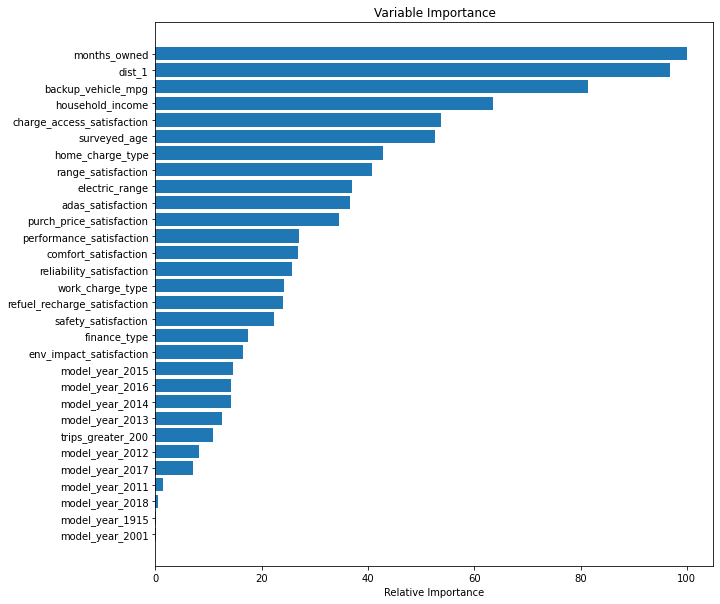

In [30]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Rebalance the data to see if it helps

### Resample the minority class (Discontinued) using SMOTE-NC algorithm


In [31]:
X.columns.tolist()

['months_owned',
 'electric_range',
 'surveyed_age',
 'dist_1',
 'trips_greater_200',
 'safety_satisfaction',
 'comfort_satisfaction',
 'refuel_recharge_satisfaction',
 'performance_satisfaction',
 'env_impact_satisfaction',
 'purch_price_satisfaction',
 'reliability_satisfaction',
 'range_satisfaction',
 'charge_access_satisfaction',
 'adas_satisfaction',
 'household_income',
 'home_charge_type',
 'work_charge_type',
 'backup_vehicle_mpg',
 'finance_type',
 'model_year_1915',
 'model_year_2001',
 'model_year_2011',
 'model_year_2012',
 'model_year_2013',
 'model_year_2014',
 'model_year_2015',
 'model_year_2016',
 'model_year_2017',
 'model_year_2018',
 'Make_',
 'Make_audi',
 'Make_bmw',
 'Make_cadillac',
 'Make_chevrolet',
 'Make_chevy',
 'Make_fiat',
 'Make_ford',
 'Make_honda',
 'Make_hyundai',
 'Make_kia',
 'Make_mercedes-benz',
 'Make_mitsubishi',
 'Make_nissan',
 'Make_smart',
 'Make_tesla',
 'Make_toyota',
 'Make_volkswagen',
 'Make_volkswagon',
 'Make_zero',
 'Model_ chevrole

In [32]:
#SMOTE-NC looks for a mask to indicate which columns are categorical(True) and which are continuous (False)
## Link to Library: https://imbalanced-learn.org/dev/references/generated/imblearn.over_sampling.SMOTENC.html

cat_mask =  np.array([True] * len(X.columns))
#Set the continuous variables to False state so the sampler knows how to handle them
cat_mask[0:2] = False
cat_mask

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [33]:
sm = SMOTENC(random_state=42, categorical_features=cat_mask)
X_res, y_res = sm.fit_resample(X, y)

In [34]:
y_res.value_counts()

continued       1530
discontinued    1530
Name: discontinuance, dtype: int64

Build the Random Forest model

In [35]:
# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.2, random_state=1)

In [36]:
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [37]:
#take a look at our hyperparameters
print('Parameters currently in use:\n')
print(clf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [39]:
n_estimators

[200, 363, 527, 690, 854, 1018, 1181, 1345, 1509, 1672, 1836, 2000]

In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 200, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 363, 527, 690,
                                                         854, 1018, 1181, 1345,
                                                         1509, 1672, 1836,
                                                         2000]},
                   random_state=42, verbose=2)

In [41]:
best_random = rf_random.best_estimator_

In [42]:
predictions = best_random.predict(X_test_scaled)
score       = best_random.score(X_test_scaled, y_test)
f1 = f1_score(y_test, predictions, average='weighted')
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

   continued       0.88      0.91      0.89       327
discontinued       0.89      0.86      0.87       285

    accuracy                           0.88       612
   macro avg       0.88      0.88      0.88       612
weighted avg       0.88      0.88      0.88       612



In [43]:
print('Best Random Forest: Accuracy=%.3f' % (score))
print('Best Random Forest: F1 Score=%.3f' % (f1))

Best Random Forest: Accuracy=0.884
Best Random Forest: F1 Score=0.884


30


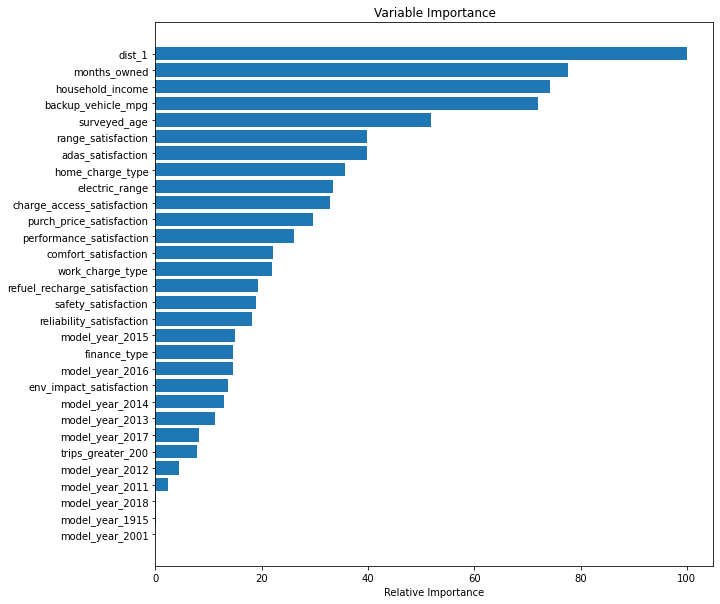

In [44]:
feature_importance = best_random.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Would it be meaningful to predict whether the first time adopters will continue / discontinue?

To-Do, try this with a label encoder rather than the one hot encoding for a tree based algorithm